# DeepFake Challenge

### Game Plan
My assumption is that fake videos have frames that are almost undetectable, and frames that are poorly generated. So I imagine a last layer that combines the frames in such a way that if enough frames are most likely fake then the entire video is most likely fake.

Also, that there are very important features in the connection between consecutive frames. Specifically, I want to try to use the delta between frames as an input, since some deep fake videos have these "jumps" of pixels that suddenly appear and disappear.

I'm going to try first to use just the frames, and later try to do manipulations on deltas to see if I can improve.

Also, I feel I need to do some more labelling and manually label some bad frames in the fake videos, that seem to the naked eye more probably fake. Or, this might not be a good idea because then the model won't work well on frames that are faked well.

And lastly, need to somehow separate fake audio from fake video for training purposes, otherwise I feel the model will be confused. Feels like it should just be 2 separate models, and combine their confidence somehow (probably take the one that is more confident about the video being fake)

##### Install Imports

In [5]:
import cv2 as cv
import pandas as pd
import numpy as np
import os
import matplotlib
# import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from fastai.vision import *

##### Install ffmpeg

In [12]:
!sudo apt update
!sudo apt install ffmpeg -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  i965-va-driver libaacs0 libass5 libasyncns0 libavc1394-0 libavcodec57
  libavdevice57 libavfilter6 libavformat57 libavresample3 libavutil55
  libbdplus0 libbluray1 libbs2b0 libcaca0 libcdio-cdda1 libcdio-paranoia1
  libcdio13 libchromaprint1 libcrystalhd3 libdc1394-22 libebur128-1 libflac8
  libflite1 libgme0 libgsm1 libiec61883-0 libjack-jackd2-0 libmp3lame0
  libmpg123-0 libnuma1 libogg0 libopenal-data libopenal1 libopencv-core2.4v5
  libopencv-imgproc2.4v5 libopenmpt0 libopus0 libpgm-5.2-0 libpostproc54
  libpulse0 libraw1394-11 librubberband2 libsamplerate0 libsdl2-2.0-0
  libshine3 libsnappy1v5 libsndfile1 libsndio6.1 libsodium18 libsoxr0
  libspeex1 libssh-gcrypt-4 libswresample2 libswscale4 libtbb2 libtheora0
  libtwolame0 libusb-1.0-0 libva-drm1 libva-x11-1 libva1 libvdpau-va-gl1
  libvdpau1 libvorbis0a libvorbisenc2 libvorbisfil

Get:74 http://deb.debian.org/debian stretch/main amd64 i965-va-driver amd64 1.7.3-1 [353 kB]
Get:75 http://deb.debian.org/debian stretch/main amd64 libaacs0 amd64 0.8.1-2 [48.6 kB]
Get:76 http://deb.debian.org/debian stretch/main amd64 libbdplus0 amd64 0.1.2-2 [46.9 kB]
Get:77 http://deb.debian.org/debian stretch/main amd64 libvdpau-va-gl1 amd64 0.4.2-1 [71.7 kB]
Get:78 http://deb.debian.org/debian stretch/main amd64 mesa-va-drivers amd64 13.0.6-1+b2 [1,460 kB]
Get:79 http://deb.debian.org/debian stretch/main amd64 mesa-vdpau-drivers amd64 13.0.6-1+b2 [1,600 kB]
Get:80 http://deb.debian.org/debian stretch/main amd64 va-driver-all amd64 1.7.3-2 [11.1 kB]
Get:81 http://deb.debian.org/debian stretch/main amd64 vdpau-driver-all amd64 1.1.1-6 [20.4 kB]
Fetched 36.5 MB in 0s (60.3 MB/s)             
Extracting templates from packages: 100%

78Selecting previously unselected package libogg0:amd64.
(Reading database ... 85881 files and directories currently installed.)
Preparing to unpack ..

Preparing to unpack .../29-libraw1394-11_2.1.2-1+b1_amd64.deb ...
Unpacking libraw1394-11:amd64 (2.1.2-1+b1) ...
7Progress: [ 22%] [############..............................................] 8Selecting previously unselected package libavc1394-0:amd64.
Preparing to unpack .../30-libavc1394-0_0.5.4-4+b1_amd64.deb ...
Unpacking libavc1394-0:amd64 (0.5.4-4+b1) ...
Selecting previously unselected package libass5:amd64.
Preparing to unpack .../31-libass5_1%3a0.13.4-2_amd64.deb ...
7Progress: [ 23%] [#############.............................................] 8Unpacking libass5:amd64 (1:0.13.4-2) ...
Selecting previously unselected package libbluray1:amd64.
Preparing to unpack .../32-libbluray1_1%3a0.9.3-3_amd64.deb ...
Unpacking libbluray1:amd64 (1:0.9.3-3) ...
7Progress: [ 24%] [##############............................................] 8Selecting previously unselected package libchromaprint1:amd64.
Preparing to unpack .../33-libchromaprint1_1.4.2-1_amd64.deb ...
Unpacking libchroma

7Progress: [ 45%] [##########################................................] 8Selecting previously unselected package libiec61883-0:amd64.
Preparing to unpack .../61-libiec61883-0_1.2.0-2_amd64.deb ...
Unpacking libiec61883-0:amd64 (1.2.0-2) ...
Selecting previously unselected package libjack-jackd2-0:amd64.
Preparing to unpack .../62-libjack-jackd2-0_1.9.10+20150825git1ed50c92~dfsg-5_amd64.deb ...
7Progress: [ 46%] [##########################................................] 8Unpacking libjack-jackd2-0:amd64 (1.9.10+20150825git1ed50c92~dfsg-5) ...
Selecting previously unselected package libopenal-data.
Preparing to unpack .../63-libopenal-data_1%3a1.17.2-4_all.deb ...
Unpacking libopenal-data (1:1.17.2-4) ...
7Progress: [ 47%] [###########################...............................] 8Selecting previously unselected package libsndio6.1:amd64.
Preparing to unpack .../64-libsndio6.1_1.1.0-3_amd64.deb ...
Unpacking libsndio6.1:amd64 (1.1.0-3) ...
7Progress: [ 48%] [##########

Setting up libmp3lame0:amd64 (3.99.5+repack1-9+b2) ...
7Progress: [ 75%] [###########################################...............] 8Setting up libusb-1.0-0:amd64 (2:1.0.21-1) ...
Setting up libcrystalhd3:amd64 (1:0.0~git20110715.fdd2f19-12) ...
7Progress: [ 76%] [############################################..............] 8Processing triggers for libc-bin (2.24-11+deb9u4) ...
ldconfig: /usr/local/cuda-10.1/targets/x86_64-linux/lib/libcudnn.so.7 is not a symbolic link

ldconfig: /usr/lib/libnvonnxparser_runtime.so.0 is not a symbolic link

ldconfig: /usr/lib/libnvonnxparser.so.0 is not a symbolic link

ldconfig: /usr/lib/libnvparsers.so.5 is not a symbolic link

ldconfig: /usr/lib/libnvinfer.so.5 is not a symbolic link

ldconfig: /usr/lib/libnvinfer_plugin.so.5 is not a symbolic link

Setting up libsnappy1v5:amd64 (1.1.3-3) ...
Setting up libbluray1:amd64 (1:0.9.3-3) ...
7Progress: [ 77%] [############################################..............] 8Setting up mesa-va-drivers:a

##### Constants

In [13]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'
TRAIN_IMAGES_FOLDER = './train'

METADATA_PATH = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, 'metadata.json')

### First Step - Prepare data as images
First I'm going to prepare the data in a nice consumable way and split the videos to images, and prepare a CSV of all frames with labels

#### Read metadata.json

In [51]:
metadata_df = pd.read_json(METADATA_PATH).T.reset_index().head(10)
metadata_df

index label  split        original
0  aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
1  aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
2  abarnvbtwb.mp4  REAL  train            None
3  abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
4  abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4
5  acifjvzvpm.mp4  FAKE  train  kbvibjhfzo.mp4
6  acqfdwsrhi.mp4  FAKE  train  ccfoszqabv.mp4
7  acxnxvbsxk.mp4  FAKE  train  fjlyaizcwc.mp4
8  acxwigylke.mp4  FAKE  train  ffcwhpnpuw.mp4
9  aczrgyricp.mp4  FAKE  train  slwkmefgde.mp4

##### Display first frame of first video

In [ ]:
first_filename = metadata_df.iloc[0].get('index')
video_file = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, first_filename)
cap = cv.VideoCapture(video_file)
success, image=cap.read()
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
Image(tensor(image.transpose(2,0,1))).show(figsize=(16,8))

#### Split all videos to image files

In [29]:
for index, row in metadata_df.iterrows():
    # get movie filename and label    
    filename = row.get('index')
    # create a folder per movie
    filename_base = filename.split('.')[0]
    dir_path = os.path.join(TRAIN_IMAGES_FOLDER, filename_base)
    !mkdir -p {dir_path}
    print(f'created dir {dir_path}')
    # split movie to images using ffmpeg and output to folder
    file_path = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, filename)
    !ffmpeg -i {file_path} -f image2 {dir_path}/{filename_base}-%03d.jpeg -v quiet
    image_files = list(os.listdir(dir_path))
    print(f'ran ffmpeg and created {len(image_files)} images')
print('finished')

created dir ./train/aagfhgtpmv
ran ffmpeg and created 300 images
created dir ./train/aapnvogymq
ran ffmpeg and created 300 images
created dir ./train/abarnvbtwb
ran ffmpeg and created 300 images
created dir ./train/abofeumbvv
ran ffmpeg and created 300 images
created dir ./train/abqwwspghj
ran ffmpeg and created 300 images
created dir ./train/acifjvzvpm
ran ffmpeg and created 300 images
created dir ./train/acqfdwsrhi
ran ffmpeg and created 300 images
created dir ./train/acxnxvbsxk
ran ffmpeg and created 300 images
created dir ./train/acxwigylke
ran ffmpeg and created 298 images
created dir ./train/aczrgyricp
ran ffmpeg and created 300 images


In [52]:
training_set = []
for index, row in metadata_df.iterrows():
    # iterate over created images and add them to training_set
    filename = row.get('index')
    label = row.get('label')
    # create a folder per movie
    filename_base = filename.split('.')[0]
    dir_path = os.path.join(TRAIN_IMAGES_FOLDER, filename_base)
    image_files = list(os.listdir(dir_path))
    image_files = map(lambda image_filename: os.path.join(filename_base, image_filename), image_files)
    image_files = map(lambda image_path: (image_path, label), image_files)
    image_files = list(image_files)
    training_set += image_files
train_df = DataFrame.from_records(training_set, columns=("name", "label"))
train_df

name label
0     aagfhgtpmv/aagfhgtpmv-106.jpeg  FAKE
1     aagfhgtpmv/aagfhgtpmv-256.jpeg  FAKE
2     aagfhgtpmv/aagfhgtpmv-132.jpeg  FAKE
3     aagfhgtpmv/aagfhgtpmv-142.jpeg  FAKE
4     aagfhgtpmv/aagfhgtpmv-003.jpeg  FAKE
...                              ...   ...
2993  aczrgyricp/aczrgyricp-081.jpeg  FAKE
2994  aczrgyricp/aczrgyricp-289.jpeg  FAKE
2995  aczrgyricp/aczrgyricp-047.jpeg  FAKE
2996  aczrgyricp/aczrgyricp-068.jpeg  FAKE
2997  aczrgyricp/aczrgyricp-223.jpeg  FAKE

[2998 rows x 2 columns]

### Second Step - Read the data into a regular ImageDataBunch

In [67]:
data = (ImageDataBunch
    .from_df(df=train_df, path=TRAIN_IMAGES_FOLDER)
    .split_by_rand_pct()
    .label_from_df()
    .transform(get_transforms(), size=256)
    .databunch(bs=64)
    .normalize(imagenet_stats))
data

You can deactivate this warning by passing `no_check=True`.


/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:271: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 1920, 1080]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1920, 1080]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), torch.Size([3, 1080, 1920]), 

AssertionError: 

### Train a regular CNN learner

##### Test the log_loss function

In [72]:
from sklearn.metrics import log_loss

log_loss(["REAL", "FAKE", "FAKE", "REAL"],
         [[.1, .9], [.9, .1], [.8, .2], [.35, .65]])

0.21616187468057912

In [73]:
learn = cnn_learner(data, models.resnet50, loss_func=log_loss, model_dir='../models')
learn

Learner(data=ImageDataBunch;

Train: LabelList (1920 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
FAKE,FAKE,FAKE,FAKE,FAKE
Path: train;

Valid: LabelList (479 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
FAKE,FAKE,FAKE,FAKE,FAKE
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv

In [74]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.17 GiB total capacity; 10.84 GiB already allocated; 4.81 MiB free; 35.16 MiB cached)

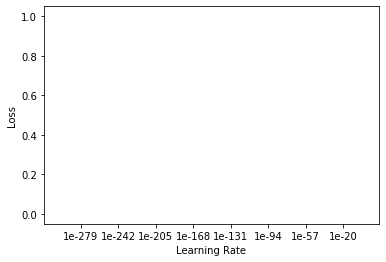

In [75]:
learn.recorder.plot()

In [ ]:
lr = 0.01
learn.fit_one_cycle(lr=lr)

### Try to use some labelled frames and only train on those

### Try to visualize the difference between the original and the fake video
Just to get a better intuition about the kind of manipulations we are trying to isolate